In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from math import sqrt
from math import log
from math import exp
from scipy.stats import boxcox 
from pandas import DataFrame
from pandas import Grouper
from pandas import Series
from pandas import concat
from pandas.plotting import lag_plot
from matplotlib import pyplot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.gofplots import qqplot
import warnings

In [4]:
df = pd.read_csv('data/zillow_data.csv')
df_income = pd.read_csv('data/zip_codes_2019_median_inc.csv')

In [5]:
df.columns = df.columns.str.strip().str.lower()
df_income.columns = df_income.columns.str.strip().str.lower()

In [6]:
df.rename(columns={'regionname': 'zipcode', 'countyname':'county'},inplace=True)
df_income.rename(columns={
    'zip code':'zipcode', 'population (2019)': 'population',
    'median family income (2019)': 'median_family_income'},
                 inplace=True)


In [7]:
df = df[df['state']=='TX']
df_income['state'] = df_income['preferred name'].str.slice(-2)
df_income = df_income[df_income['state']=='TX']
df_income = (df_income[df_income['type'] != 'PO box'])

In [8]:
df_income.head()


,zipcode,type,state fips,preferred name,alternate names,population,housing units (2019),median_family_income,mfi percentile (2019),latitude,longitude,land area,water area,state
31142,73301,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31143,73344,unique,48,"Austin, TX",Irs Service Center,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TX
31744,75001,standard,48,"Addison, TX",NaN,"14,992","9,298","$79,551",68.0,32.959999,-96.838997,3.834,0.003,TX
31745,75002,standard,48,"Allen, TX","Lucas, Parker","71,253","23,314","$105,656",88.0,33.090000,-96.609001,37.179,2.056,TX
31746,75006,standard,48,"Carrollton, TX",NaN,"51,642","19,178","$72,325",57.0,32.962002,-96.899002,16.875,0.254,TX


In [9]:
#Calculate historical return on investment
df['ROI']= (df['2018-04']/df['1996-04'])-1
df['ROI']


#Calculate standard deviation of monthly values
df['std']=df.loc[:,'1996-04':'2018-04'].std(skipna=True, axis=1)

#Calculate historical mean value
df['mean']=df.loc[:,'1996-04':'2018-04'].mean(skipna=True, axis=1)

#Calculate coefficient of variance
df['CV']=df['std']/df['mean']

#Show calculated values
df[['zipcode','std','mean','ROI','CV']].head()

#Descriptive statistics of coefficients of variance.
print(df.CV.describe())

#Define upper limit of CV according to risk profile.
upper_cv = df.CV.quantile(.6)
print(f'\nCV upper limit: {upper_cv}')

#Get the 5 zipcodes with highest ROIs within the firms risk profile.
zc_best5 = df[df['CV']<upper_cv].sort_values('ROI',axis=0,ascending=False)[:5]
print('\n Best 5 Zipcodes:')
zc_best5[['zipcode','ROI','CV']]

warnings.filterwarnings

count    989.000000
mean       0.167433
std        0.041415
min        0.045182
25%        0.142279
50%        0.165783
75%        0.189448
max        0.361446
Name: CV, dtype: float64

CV upper limit: 0.17479440936725246

 Best 5 Zipcodes:


<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [10]:
df.drop(['regionid', 'sizerank', 'metro'], axis=1,inplace=True)

In [11]:
df_income = df_income[df_income.columns[np.r_[0,5,7,9:11]]]
df_income


,zipcode,population,median_family_income,latitude,longitude
31142,73301,NaN,NaN,NaN,NaN
31143,73344,NaN,NaN,NaN,NaN
31744,75001,"14,992","$79,551",32.959999,-96.838997
31745,75002,"71,253","$105,656",33.090000,-96.609001
31746,75006,"51,642","$72,325",32.962002,-96.899002
...,...,...,...,...,...
34257,79961,NaN,NaN,NaN,NaN
34258,79968,NaN,NaN,NaN,NaN
34259,79976,NaN,NaN,NaN,NaN
34260,79978,NaN,NaN,NaN,NaN


In [12]:
# fixing mfi and pop columns
df_income['median_family_income'] = df_income['median_family_income'].str.strip('$\n\t')
df_income['median_family_income'] = df_income['median_family_income'].str.replace(',','')
df_income = df_income[df_income['median_family_income'].notna()]
df_income['median_family_income'] = df_income['median_family_income'].astype(int)
df_income['population'] = df_income['population'].str.replace(',','')
df_income['population'] = df_income['population'].astype(int)

<ipython-input-12-07f5f36c8a35>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['median_family_income'] = df_income['median_family_income'].astype(int)
<ipython-input-12-07f5f36c8a35>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_income['population'] = df_income['population'].str.replace(',','')
<ipython-input-12-07f5f36c8a35>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveat

In [13]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['zipcode', 'city', 'state', 'county','ROI','std','mean','CV'], var_name='date')
    melted['date'] = pd.to_datetime(melted['date'], infer_datetime_format=True)
    melted['year'] = [d.year for d in melted.date]
    melted = melted.dropna(subset=['value'])
    return melted

In [14]:
df = melt_data(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 255096 entries, 0 to 262084
Data columns (total 11 columns):
 #   Column   Non-Null Count   Dtype         
---  ------   --------------   -----         
 0   zipcode  255096 non-null  int64         
 1   city     255096 non-null  object        
 2   state    255096 non-null  object        
 3   county   255096 non-null  object        
 4   ROI      250160 non-null  float64       
 5   std      255096 non-null  float64       
 6   mean     255096 non-null  float64       
 7   CV       255096 non-null  float64       
 8   date     255096 non-null  datetime64[ns]
 9   value    255096 non-null  float64       
 10  year     255096 non-null  int64         
dtypes: datetime64[ns](1), float64(5), int64(2), object(3)
memory usage: 23.4+ MB


In [15]:
df.set_index(df['date'], inplace = True)
df.drop('date',axis=1, inplace=True)
df

,zipcode,city,state,county,ROI,std,mean,CV,value,year
date,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [16]:
df_merged = df.reset_index().merge(df_income, how='left').set_index('date')
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 255096 entries, 1996-04-01 to 2018-04-01
Data columns (total 14 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   zipcode               255096 non-null  int64  
 1   city                  255096 non-null  object 
 2   state                 255096 non-null  object 
 3   county                255096 non-null  object 
 4   ROI                   250160 non-null  float64
 5   std                   255096 non-null  float64
 6   mean                  255096 non-null  float64
 7   CV                    255096 non-null  float64
 8   value                 255096 non-null  float64
 9   year                  255096 non-null  int64  
 10  population            252181 non-null  float64
 11  median_family_income  252181 non-null  float64
 12  latitude              252181 non-null  float64
 13  longitude             252181 non-null  float64
dtypes: float64(9), int64(2), object(3)
m

In [17]:
df_merged.describe().T


,count,mean,std,min,25%,50%,75%,max
zipcode,255096.0,77163.777546,1361.342308,75001.000000,76017.000000,77098.000000,78251.000000,7.993800e+04
ROI,250160.0,0.940549,0.418125,-0.375469,0.721048,0.903395,1.101759,6.550360e+00
std,255096.0,23762.532113,16134.709292,2684.773009,13998.832825,19663.932774,29134.083926,1.437548e+05
mean,255096.0,140540.600793,94822.092356,32718.292683,81482.641509,115224.150943,165333.207547,8.802596e+05
CV,255096.0,0.168955,0.040480,0.045182,0.144163,0.166917,0.189818,3.614458e-01
value,255096.0,140540.600793,99061.016727,24100.000000,79900.000000,113700.000000,165100.000000,1.268600e+06
year,255096.0,2006.908003,6.393508,1996.000000,2001.000000,2007.000000,2012.000000,2.018000e+03
population,252181.0,25939.370892,20385.536014,1056.000000,9761.000000,21879.000000,37281.000000,1.282940e+05
median_family_income,252181.0,77689.448301,32642.262099,21169.000000,56108.000000,69722.000000,90867.000000,2.500010e+05
latitude,252181.0,31.108154,1.797547,25.944000,29.736000,30.805000,32.723999,3.604600e+01


In [18]:
df_merged_upper_pop = df_merged['population'].quantile(.75)
df_filtered = df_merged[(df_merged['population'] > df_merged_upper_pop)]

In [19]:
# Select the first quantile
q1 = df_filtered['value'].quantile(.25)

# Select the third quantile
q3 = df_filtered['value'].quantile(.75)


# Create a filtered in between q1 & q3
filtered = df_filtered[(df_filtered['value']>=q1) 
             & (df_filtered['value']<=q3)]
df_filtered = pd.DataFrame(filtered)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 31421 entries, 1996-04-01 to 2018-04-01
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   zipcode               31421 non-null  int64  
 1   city                  31421 non-null  object 
 2   state                 31421 non-null  object 
 3   county                31421 non-null  object 
 4   ROI                   31421 non-null  float64
 5   std                   31421 non-null  float64
 6   mean                  31421 non-null  float64
 7   CV                    31421 non-null  float64
 8   value                 31421 non-null  float64
 9   year                  31421 non-null  int64  
 10  population            31421 non-null  float64
 11  median_family_income  31421 non-null  float64
 12  latitude              31421 non-null  float64
 13  longitude             31421 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 3.6+

In [20]:
# group by date and aggregate on median value
df_filtered['median_house_price'] = df_filtered.groupby('date').aggregate({'value':'median'})
df_filtered['affordability'] = df_filtered['value'] - df_filtered['median_family_income']/.12

In [21]:
# create function to normalize data
def normalize_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
df_filtered['affordability_score']  = normalize_data(df_filtered['affordability'])
df_filtered

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
1996-04-01,78660,Pflugerville,TX,Travis,0.748020,24894.592870,168193.584906,0.148012,138900.0,1996,91300.0,99733.0,30.440001,-97.595001,124500.0,-692208.333333,0.409033
1996-04-01,77573,League City,TX,Galveston,0.848656,29647.359699,183261.509434,0.161776,141400.0,1996,88131.0,121943.0,29.504000,-95.086998,124500.0,-874791.666667,0.221835
1996-04-01,77584,Pearland,TX,Brazoria,0.851986,27064.756641,188628.301887,0.143482,138500.0,1996,90372.0,126143.0,29.545000,-95.350998,124500.0,-912691.666667,0.182977
1996-04-01,79912,El Paso,TX,El Paso,0.571429,26245.575483,154012.075472,0.170412,119700.0,1996,78267.0,77146.0,31.849001,-106.533997,124500.0,-523183.333333,0.582329
1996-04-01,78130,New Braunfels,TX,Comal,0.784504,23349.861603,153368.301887,0.152247,123900.0,1996,77400.0,76824.0,29.694000,-98.072998,124500.0,-516300.000000,0.589387
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-04-01,78552,Harlingen,TX,Cameron,0.468835,9181.535729,85940.377358,0.106836,108400.0,2018,37948.0,52891.0,26.194000,-97.750999,144750.0,-332358.333333,0.777977
2018-04-01,77014,Houston,TX,Harris,0.619588,15782.797130,122692.452830,0.128637,157100.0,2018,37488.0,55613.0,29.981001,-95.463997,144750.0,-306341.666667,0.804651
2018-04-01,77506,Pasadena,TX,Harris,1.255187,12538.003841,69982.264151,0.179160,108700.0,2018,38765.0,46462.0,29.714001,-95.199997,144750.0,-278483.333333,0.833214


In [22]:
# filtering to the 20th percentile
top_20 = df_filtered['affordability_score'].quantile(.5)
top_20

0.5827053536337383

In [23]:
df_filtered_20 = df_filtered[(df_filtered['affordability_score'] < top_20)]

In [24]:
df_filtered_20.reset_index().isna().sum()

date                    0
zipcode                 0
city                    0
state                   0
county                  0
ROI                     0
std                     0
mean                    0
CV                      0
value                   0
year                    0
population              0
median_family_income    0
latitude                0
longitude               0
median_house_price      0
affordability           0
affordability_score     0
dtype: int64

In [25]:
df_filtered_20 = df_filtered_20['2017-01-01':].dropna()

In [26]:
df_filtered_20 = df_filtered_20.reset_index()
df_filtered_20 = df_filtered_20.loc[df_filtered_20.groupby("zipcode")["ROI"].idxmax()].sort_values('ROI',axis=0,ascending=False)[:5]
df_filtered_20.set_index('date',inplace=True)
df_filtered_20

,zipcode,city,state,county,ROI,std,mean,CV,value,year,population,median_family_income,latitude,longitude,median_house_price,affordability,affordability_score
date,,,,,,,,,,,,,,,,,
2017-01-01,79423,Lubbock,TX,Lubbock,1.082037,21451.329003,105156.226415,0.203995,139000.0,2017,40303.0,82989.0,33.439999,-101.855003,145050.0,-552575.000000,0.552195
2017-01-01,77571,La Porte,TX,Harris,1.040936,20507.800452,116197.358491,0.176491,153100.0,2017,37427.0,85150.0,29.688000,-95.056999,145050.0,-556483.333333,0.548188
2017-01-01,76108,Fort Worth,TX,Tarrant,1.013480,17152.126989,106005.660377,0.161804,143500.0,2017,43169.0,80040.0,32.787998,-97.524002,145050.0,-523500.000000,0.582005
2017-01-01,75052,Grand Prairie,TX,Dallas,0.995040,19370.586349,134230.188679,0.144309,176200.0,2017,95495.0,85220.0,32.665001,-97.025002,145050.0,-533966.666667,0.571274
2017-01-01,75104,Cedar Hill,TX,Dallas,0.954222,18302.905606,129367.924528,0.141479,166100.0,2017,49171.0,83143.0,32.580002,-96.964996,145050.0,-526758.333333,0.578664


In [27]:
zipcodes = list(df_filtered_20['zipcode'].values)

In [28]:
df_filtered_20 = df_filtered_20[df_filtered_20['zipcode'].isin(zipcodes)]

In [29]:
df_merged = df_merged[df_merged['zipcode'].isin(zipcodes)]

In [30]:
df_merged['zipcode'].value_counts()

77571    265
79423    265
75104    265
75052    265
76108    265
Name: zipcode, dtype: int64

In [31]:
df_prices = pd.DataFrame(df_merged[['zipcode', 'value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

In [32]:
df_p = df_prices.pivot("date", "zipcode", "value")
df_p

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,100800.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,100900.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,101000.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,101000.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,101200.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,194300.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,195200.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,196700.0,189100.0,161900.0,173100.0,148200.0


In [33]:
df_p.columns

Int64Index([75052, 75104, 76108, 77571, 79423], dtype='int64', name='zipcode')

# 77571

In [34]:
df_77571 = pd.DataFrame(df_p[77571][df_p[77571].notnull()]).astype(int) 
df_77571['value'] = df_77571[77571] 
df_77571.drop(df_77571.columns[np.r_[1]], axis=1, inplace=True)

In [35]:
df_77571

,77571
date,
1996-04-01,85500
1996-05-01,85600
1996-06-01,85800
1996-07-01,85900
1996-08-01,86000
...,...
2017-12-01,170300
2018-01-01,171800
2018-02-01,173100


<AxesSubplot:xlabel='date'>

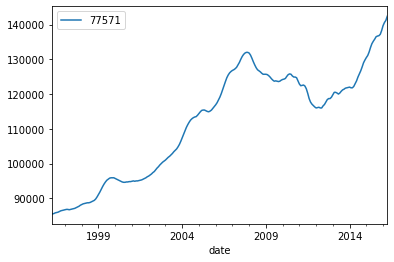

In [36]:
train = df_77571[:-24]
test = df_77571[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

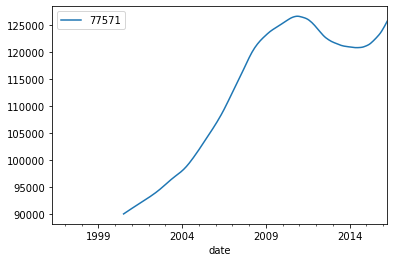

In [37]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

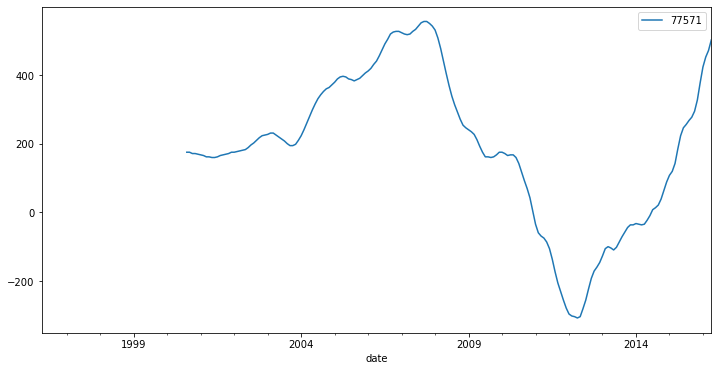

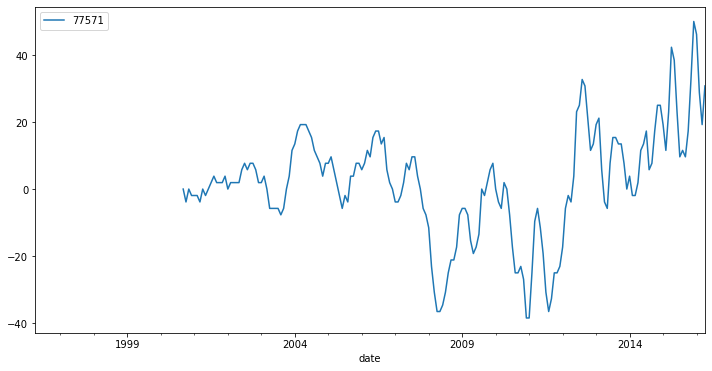

In [38]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [39]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

Results of Dickey-Fuller Test: 

Test Statistic                   0.511947
p-value                          0.985232
#Lags Used                       5.000000
Number of Observations Used    259.000000
Critical Value (1%)             -3.455853
Critical Value (5%)             -2.872765
Critical Value (10%)            -2.572752
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.400236
p-value                          0.141670
#Lags Used                       4.000000
Number of Observations Used    183.000000
Critical Value (1%)             -3.466598
Critical Value (5%)             -2.877467
Critical Value (10%)            -2.575260
dtype: float64
None


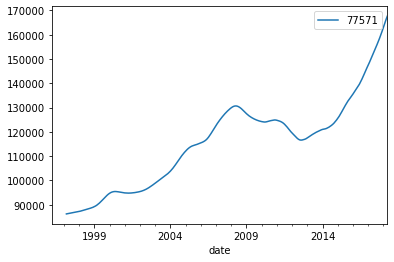

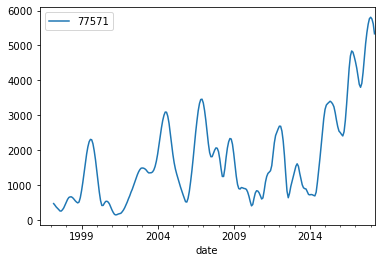

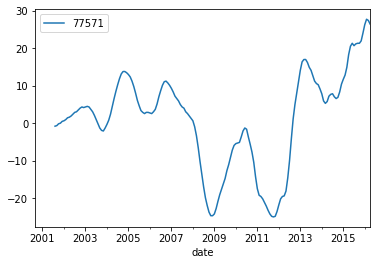

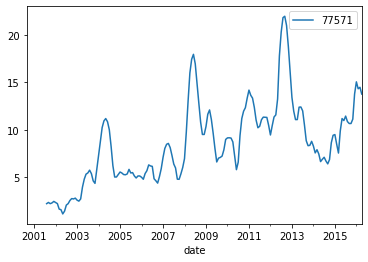

In [40]:
print(stationarity_check(df_77571))
print(stationarity_check(rm_diff_2.dropna()))

In [41]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  77571   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1859.208
Date:                Thu, 07 Oct 2021   AIC                           3724.416
Time:                        10:16:52   BIC                           3734.871
Sample:                    04-01-1996   HQIC                          3728.628
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.119e+05   2.78e+04      4.022      0.000    5.74e+04    1.66e+05
ar.L1          0.9998      0.002    404.155      0.000       0.995       1.005
sigma2      2.845e+05    2.8e+04     10.152      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [42]:
y_train_hat = sm.predict()
y_train_hat

1996-04-01    111897.937931
1996-05-01     85505.226847
1996-06-01     85605.207047
1996-07-01     85805.167446
1996-08-01     85905.147646
                  ...      
2015-12-01    137194.990139
2016-01-01    138294.772337
2016-02-01    139694.495134
2016-03-01    140594.316932
2016-04-01    141194.198131
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [43]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1781.8310236201232

In [44]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  77571   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1860.654
Date:                Thu, 07 Oct 2021   AIC                           3725.309
Time:                        10:16:52   BIC                           3732.278
Sample:                    04-01-1996   HQIC                          3728.117
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   7.73e-05   1.29e+04      0.000       1.000       1.000
sigma2      2.838e+05   2.48e-14   1.14e+19      0.000    2.84e+05    2.84e+05
===================================================================================
Ljung-Box (L1) (Q):                 192.78   Jarque-Bera (JB):                12.64
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.55   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.83
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.66e+34. Standard errors may be unstable.
"""

In [45]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1781.8310236201232

In [46]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [47]:
def plot_predictions(test=test, sarimax=sarimax):
    
    '''
    Pass a test set, as well as a model fit to the training set 
    to this function, and plot the test predictions against
    the true test values
    '''
    
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

In [48]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(test, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  77571   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1922.439
Date:                Thu, 07 Oct 2021   AIC                           3850.877
Time:                        10:16:52   BIC                           3861.332
Sample:                    04-01-1998   HQIC                          3855.089
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.191e+05   5.74e-12   2.08e+16      0.000    1.19e+05    1.19e+05
ar.L1          0.9999      0.001   1738.592      0.000       0.999       1.001
sigma2      4.816e+05   2.22e-12   2.17e+17      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [49]:
test_hat = sm.predict()
test_hat

1998-04-01    119117.884197
1998-05-01     88604.281188
1998-06-01     88704.267159
1998-07-01     88704.267159
1998-08-01     88804.253131
                  ...      
2017-12-01    168593.058424
2018-01-01    170292.819940
2018-02-01    171792.609513
2018-03-01    173092.427143
2018-04-01    174092.286859
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [50]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, test_hat, squared=False)
rmse

2084.139273463448

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:996: UserWarning: Non-stationary starting seasonal autoregressive Using zeros as starting parameters.
  warn('Non-stationary starting seasonal autoregressive'


6224.871676406875
6003.251299046528


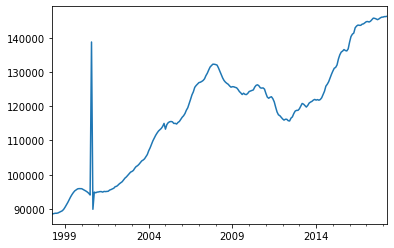

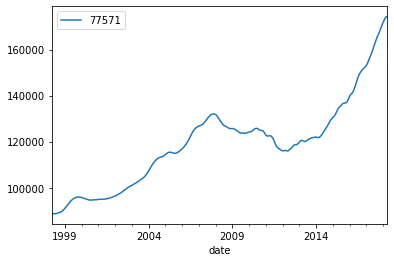

In [51]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

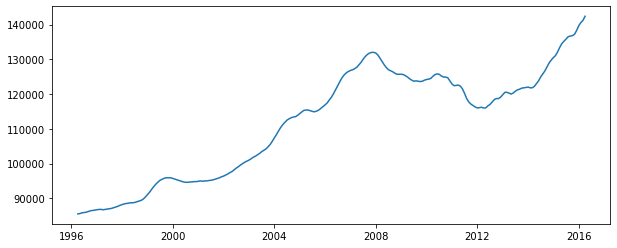

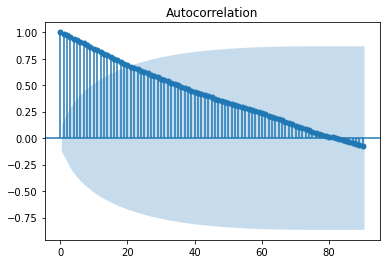

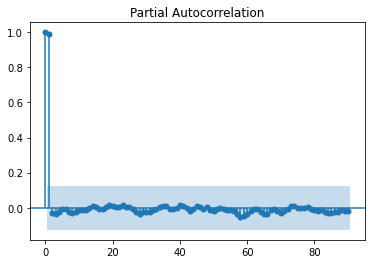

In [52]:
plt.figure(figsize=(10, 4))

plt.plot(train)
plt.show()
plot_acf(train, lags=90) 
plt.show()
plot_pacf(train, lags=90) 
plt.show()

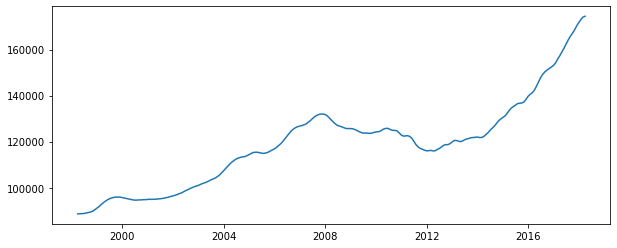

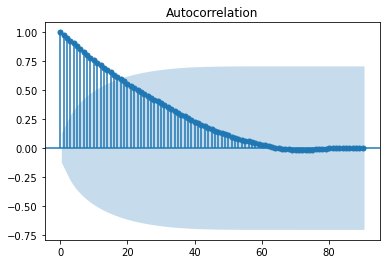

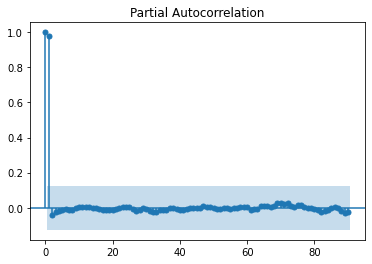

In [53]:
plt.figure(figsize=(10, 4))

plt.plot(test)
plt.show()
plot_acf(test, lags=90) 
plt.show()
plot_pacf(test, lags=90) 
plt.show()

# 76108

In [54]:
df_76108 = pd.DataFrame(df_p[76108][df_p[76108].notnull()]).astype(int) 
df_76108['value'] = df_76108[76108] 
df_76108.drop(df_76108.columns[np.r_[1]], axis=1, inplace=True)

In [55]:
df_76108

,76108
date,
1996-04-01,81600
1996-05-01,81500
1996-06-01,81400
1996-07-01,81400
1996-08-01,81400
...,...
2017-12-01,158300
2018-01-01,160100
2018-02-01,161900


<AxesSubplot:xlabel='date'>

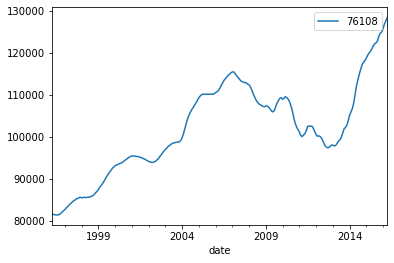

In [56]:
train = df_76108[:-24]
test = df_76108[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

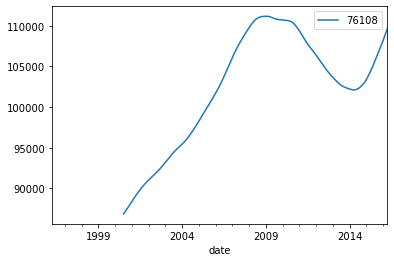

In [57]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

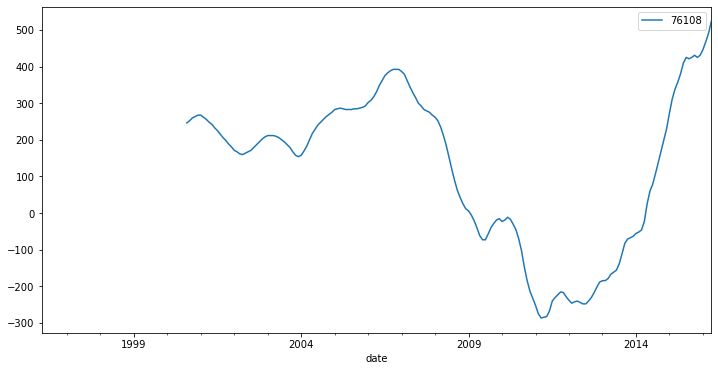

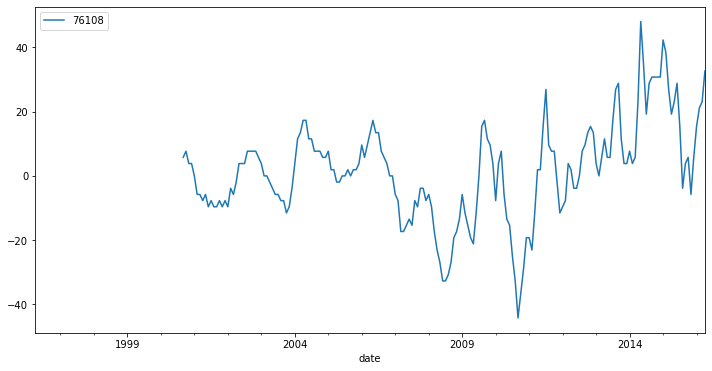

In [58]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [59]:
def stationarity_check(df):
    roll_mean = df.rolling(window=12, center=False).mean()
    roll_std = df.rolling(window=12, center=False).std()
    
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    roll_mean.plot()
    roll_std.plot()
    return None

Results of Dickey-Fuller Test: 

Test Statistic                   0.316514
p-value                          0.978090
#Lags Used                      15.000000
Number of Observations Used    249.000000
Critical Value (1%)             -3.456888
Critical Value (5%)             -2.873219
Critical Value (10%)            -2.572994
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -0.982786
p-value                          0.759491
#Lags Used                      14.000000
Number of Observations Used    173.000000
Critical Value (1%)             -3.468726
Critical Value (5%)             -2.878396
Critical Value (10%)            -2.575756
dtype: float64
None


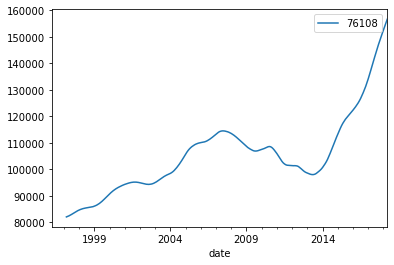

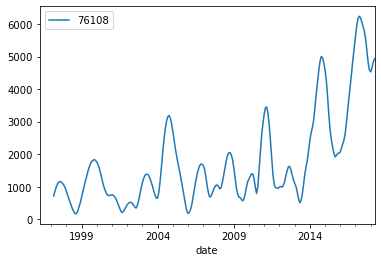

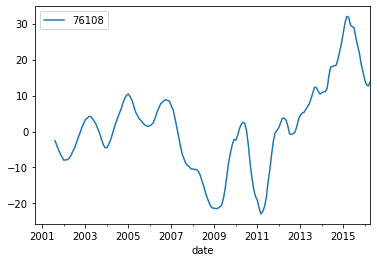

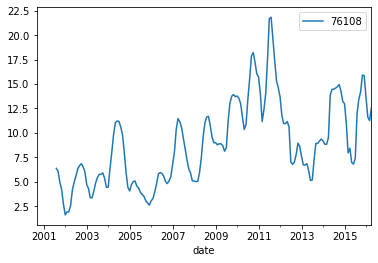

In [60]:
print(stationarity_check(df_76108))
print(stationarity_check(rm_diff_2.dropna()))

In [61]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())


                               SARIMAX Results                                
Dep. Variable:                  76108   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1867.405
Date:                Thu, 07 Oct 2021   AIC                           3740.810
Time:                        10:16:57   BIC                           3751.264
Sample:                    04-01-1996   HQIC                          3745.022
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.018e+05   4.23e+04      2.406      0.016    1.89e+04    1.85e+05
ar.L1          0.9997      0.004    240.326      0.000       0.992       1.008
sigma2      3.052e+05   2.33e+04     13.084      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [62]:
y_train_hat = sm.predict()
y_train_hat

1996-04-01    101836.536531
1996-05-01     81606.082672
1996-06-01     81506.112730
1996-07-01     81406.142788
1996-08-01     81406.142788
                  ...      
2015-12-01    124593.157788
2016-01-01    124893.067614
2016-02-01    125692.827151
2016-03-01    126792.496515
2016-04-01    127492.286109
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [63]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1415.39687933285

In [64]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  76108   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1868.954
Date:                Thu, 07 Oct 2021   AIC                           3741.907
Time:                        10:16:57   BIC                           3748.877
Sample:                    04-01-1996   HQIC                          3744.715
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.11e-05   1.23e+04      0.000       1.000       1.000
sigma2      3.052e+05   3.24e-14   9.42e+18      0.000    3.05e+05    3.05e+05
===================================================================================
Ljung-Box (L1) (Q):                 192.21   Jarque-Bera (JB):                22.43
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               7.49   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.49
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [65]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, y_train_hat, squared=False)
rmse

1415.39687933285

In [66]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(test, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())


                               SARIMAX Results                                
Dep. Variable:                  76108   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1936.030
Date:                Thu, 07 Oct 2021   AIC                           3878.060
Time:                        10:16:57   BIC                           3888.514
Sample:                    04-01-1998   HQIC                          3882.272
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.082e+05   1.86e-12   5.81e+16      0.000    1.08e+05    1.08e+05
ar.L1          0.9999      0.000   2569.788      0.000       0.999       1.001
sigma2      5.367e+05   6.51e-13   8.25e+17      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [67]:
test_hat = sm.predict()
test_hat

1998-04-01    108245.280203
1998-05-01     85503.274327
1998-06-01     85603.259932
1998-07-01     85603.259932
1998-08-01     85703.245536
                  ...      
2017-12-01    156393.067823
2018-01-01    158292.794306
2018-02-01    160092.535184
2018-03-01    161892.276063
2018-04-01    163392.060128
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [68]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, test_hat, squared=False)
rmse


1638.1959429220808

In [69]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [70]:
def plot_predictions(test=test, sarimax=sarimax):
    
    '''
    Pass a test set, as well as a model fit to the training set 
    to this function, and plot the test predictions against
    the true test values
    '''
    
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


6077.96048247966
7956.883975274661


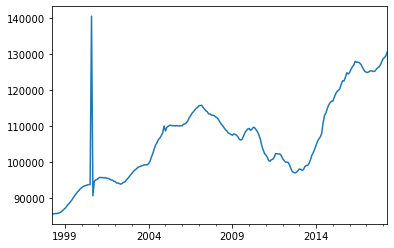

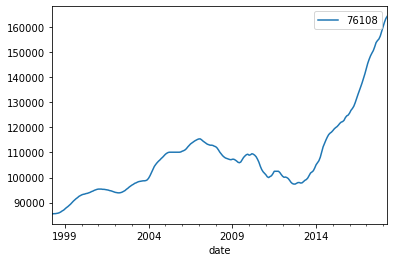

In [71]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

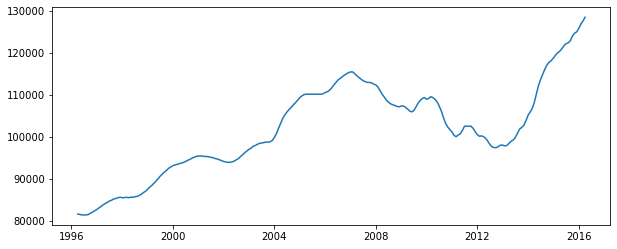

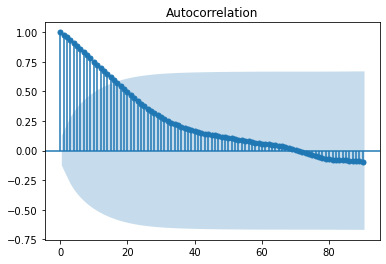

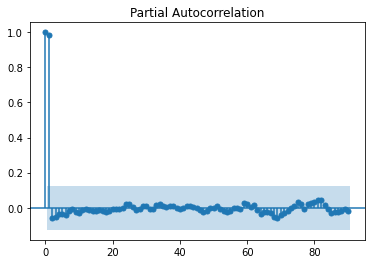

In [72]:
plt.figure(figsize=(10, 4))

plt.plot(train)
plt.show()
plot_acf(train, lags=90) 
plt.show()
plot_pacf(train, lags=90) 
plt.show()

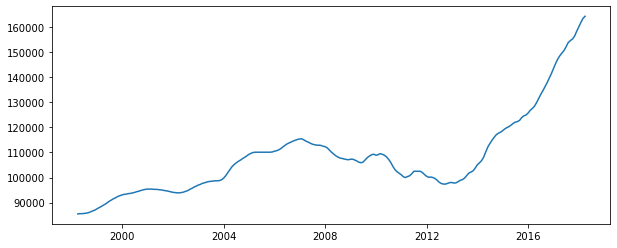

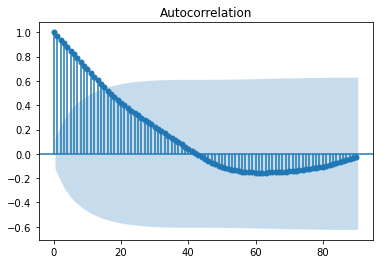

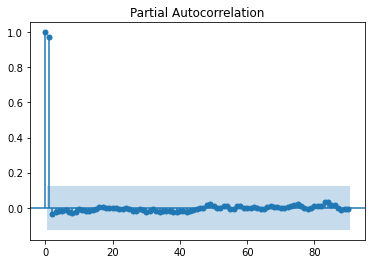

In [73]:
plt.figure(figsize=(10, 4))

plt.plot(test)
plt.show()
plot_acf(test, lags=90) 
plt.show()
plot_pacf(test, lags=90) 
plt.show()

# 75052

In [74]:
df_75052 = pd.DataFrame(df_p[75052][df_p[75052].notnull()]).astype(int) 
df_75052['value'] = df_75052[75052] 
df_75052.drop(df_75052.columns[np.r_[1]], axis=1, inplace=True)

In [75]:
df_75052

,75052
date,
1996-04-01,100800
1996-05-01,100900
1996-06-01,101000
1996-07-01,101000
1996-08-01,101200
...,...
2017-12-01,194300
2018-01-01,195200
2018-02-01,196700


<AxesSubplot:xlabel='date'>

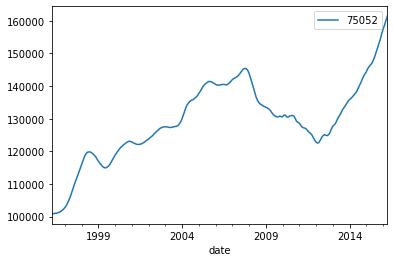

In [76]:
train = df_75052[:-24]
test = df_75052[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

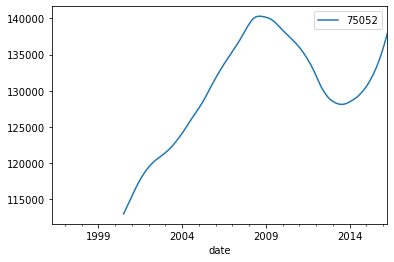

In [77]:

# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

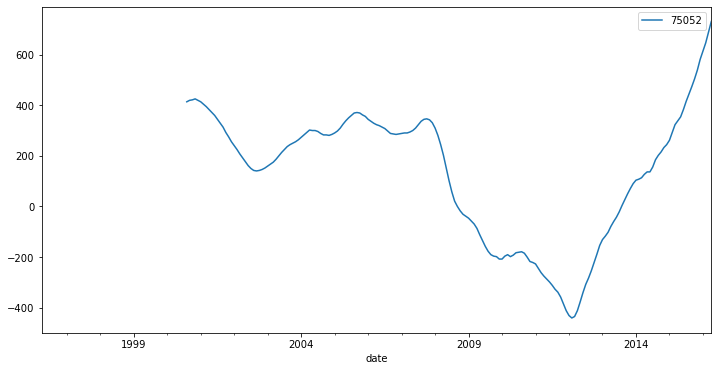

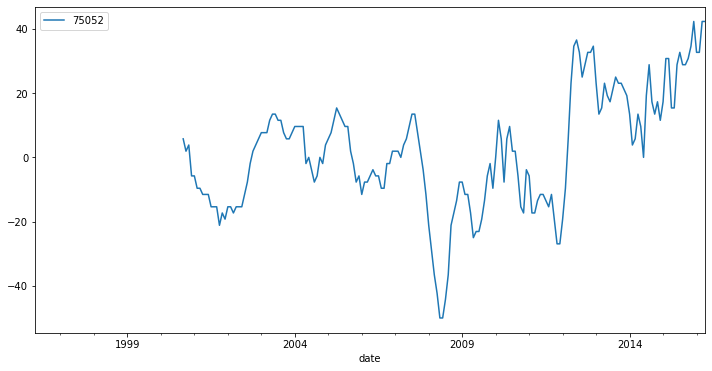

In [78]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [79]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [80]:
print(stationarity_check(df_75052))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                   0.765594
p-value                          0.991060
#Lags Used                       6.000000
Number of Observations Used    258.000000
Critical Value (1%)             -3.455953
Critical Value (5%)             -2.872809
Critical Value (10%)            -2.572775
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.682298
p-value                          0.077152
#Lags Used                       3.000000
Number of Observations Used    184.000000
Critical Value (1%)             -3.466398
Critical Value (5%)             -2.877380
Critical Value (10%)            -2.575214
dtype: float64
None


In [81]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  75052   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1905.280
Date:                Thu, 07 Oct 2021   AIC                           3816.561
Time:                        10:17:03   BIC                           3827.015
Sample:                    04-01-1996   HQIC                          3820.772
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.294e+05   2.95e+04      4.392      0.000    7.17e+04    1.87e+05
ar.L1          0.9998      0.003    369.171      0.000       0.994       1.005
sigma2      4.176e+05   4.08e+04     10.238      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [82]:
train_hat = sm.predict()
train_hat

1996-04-01    129427.809375
1996-05-01    100807.098395
1996-06-01    100907.073599
1996-07-01    101007.048804
1996-08-01    101007.048804
                  ...      
2015-12-01    154293.832828
2016-01-01    155993.411305
2016-02-01    157393.064169
2016-03-01    158592.766623
2016-04-01    159992.419487
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [83]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

1953.5678167105066

In [84]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  75052   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1906.803
Date:                Thu, 07 Oct 2021   AIC                           3817.606
Time:                        10:17:04   BIC                           3824.576
Sample:                    04-01-1996   HQIC                          3820.414
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   8.01e-05   1.25e+04      0.000       1.000       1.000
sigma2      4.159e+05   1.64e-14   2.54e+19      0.000    4.16e+05    4.16e+05
===================================================================================
Ljung-Box (L1) (Q):                 210.55   Jarque-Bera (JB):                 3.78
Prob(Q):                              0.00   Prob(JB):                         0.15
Heteroskedasticity (H):               1.50   Skew:                            -0.29
Prob(H) (two-sided):                  0.07   Kurtosis:                         3.22
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.43e+35. Standard errors may be unstable.
"""

In [85]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

1953.5678167105066

In [86]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(test, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                               SARIMAX Results                                
Dep. Variable:                  75052   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1954.677
Date:                Thu, 07 Oct 2021   AIC                           3915.354
Time:                        10:17:04   BIC                           3925.808
Sample:                    04-01-1998   HQIC                          3919.566
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.37e+05   6.06e-13   2.26e+17      0.000    1.37e+05    1.37e+05
ar.L1          0.9999      0.000   3481.125      0.000       0.999       1.000
sigma2      6.303e+05   2.77e-13   2.28e+18      0.0

In [87]:
test_hat = sm.predict()
test_hat

1998-04-01    136954.062974
1998-05-01    119202.260506
1998-06-01    119702.196844
1998-07-01    119802.184112
1998-08-01    119802.184112
                  ...      
2017-12-01    192992.864047
2018-01-01    194292.698527
2018-02-01    195192.583936
2018-03-01    196692.392951
2018-04-01    199092.087375
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [88]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, test_hat, squared=False)
rmse

1390.9943654202464

In [89]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [90]:
def plot_predictions(test=test, sarimax=sarimax):
    
    '''
    Pass a test set, as well as a model fit to the training set 
    to this function, and plot the test predictions against
    the true test values
    '''
    
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


7662.566172289925
7104.643034173993


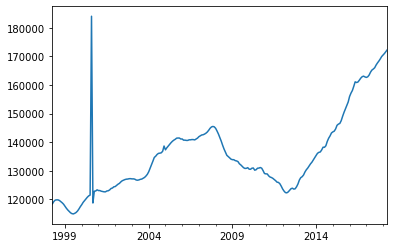

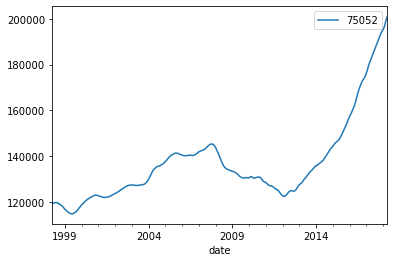

In [91]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

# 75104¶

In [92]:
df_75104 = pd.DataFrame(df_p[75104][df_p[75104].notnull()]).astype(int) 
df_75104['value'] = df_75104[75104] 
df_75104.drop(df_75104.columns[np.r_[1]], axis=1, inplace=True)
df_75104

,75104
date,
1996-04-01,98300
1996-05-01,98500
1996-06-01,98700
1996-07-01,99000
1996-08-01,99200
...,...
2017-12-01,184400
2018-01-01,187000
2018-02-01,189100


<AxesSubplot:xlabel='date'>

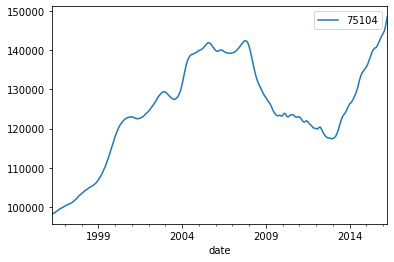

In [93]:
train =  df_75104[:-24]
test = df_75104[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

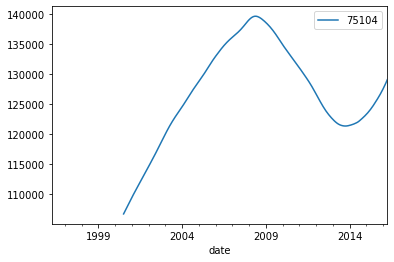

In [94]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

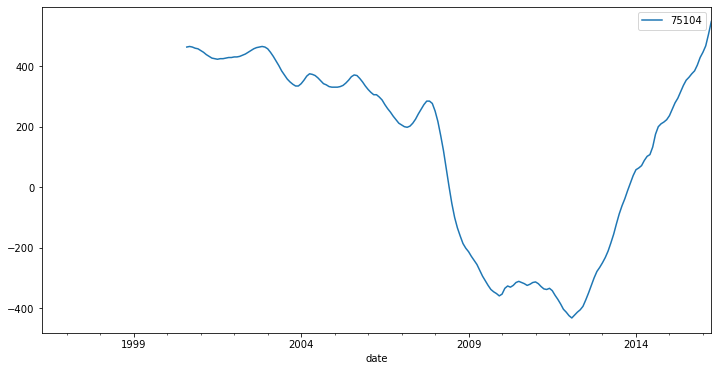

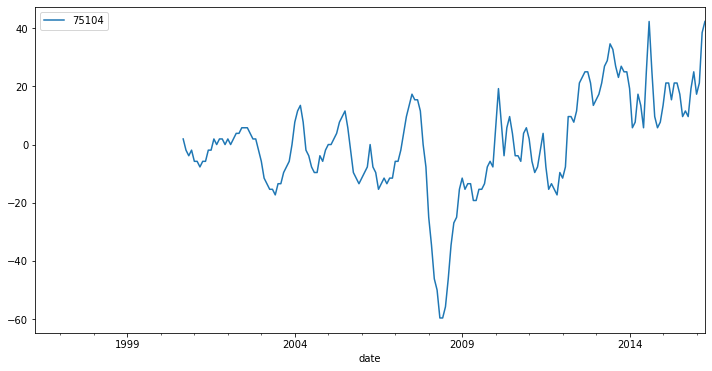

In [95]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [96]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [97]:
print(stationarity_check(df_75104))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                  -0.544195
p-value                          0.883100
#Lags Used                      13.000000
Number of Observations Used    251.000000
Critical Value (1%)             -3.456674
Critical Value (5%)             -2.873125
Critical Value (10%)            -2.572944
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -1.724024
p-value                          0.418779
#Lags Used                      15.000000
Number of Observations Used    172.000000
Critical Value (1%)             -3.468952
Critical Value (5%)             -2.878495
Critical Value (10%)            -2.575809
dtype: float64
None


In [98]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  75104   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1896.228
Date:                Thu, 07 Oct 2021   AIC                           3798.456
Time:                        10:17:12   BIC                           3808.910
Sample:                    04-01-1996   HQIC                          3802.668
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.251e+05   3.21e+04      3.901      0.000    6.23e+04    1.88e+05
ar.L1          0.9997      0.003    311.712      0.000       0.993       1.006
sigma2       3.88e+05   3.13e+04     12.412      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


In [99]:
train_hat = sm.predict()
train_hat

1996-04-01    125149.784718
1996-05-01     98309.110350
1996-06-01     98509.042488
1996-07-01     98708.974627
1996-08-01     99008.872834
                  ...      
2015-12-01    142794.011139
2016-01-01    143593.739692
2016-02-01    144193.536107
2016-03-01    144893.298592
2016-04-01    146492.755699
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [100]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

1837.682587025306

In [101]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(test, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  75104   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1972.556
Date:                Thu, 07 Oct 2021   AIC                           3951.113
Time:                        10:17:12   BIC                           3961.567
Sample:                    04-01-1998   HQIC                          3955.324
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.322e+05   2.35e-12   5.64e+16      0.000    1.32e+05    1.32e+05
ar.L1          0.9998      0.000   2246.062      0.000       0.999       1.001
sigma2      7.263e+05   6.65e-13   1.09e+18      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [102]:
test_hat = sm.predict()
test_hat

1998-04-01    132197.973184
1998-05-01    104404.274351
1998-06-01    104604.243598
1998-07-01    104904.197469
1998-08-01    105104.166716
                  ...      
2017-12-01    181992.342199
2018-01-01    184391.973163
2018-02-01    186991.573375
2018-03-01    189091.250468
2018-04-01    190790.989068
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [103]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, test_hat, squared=False)
rmse

1983.3172020257603

In [104]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [105]:
def plot_predictions(test=test, sarimax=sarimax):
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


7445.643751850351
8944.656014177834


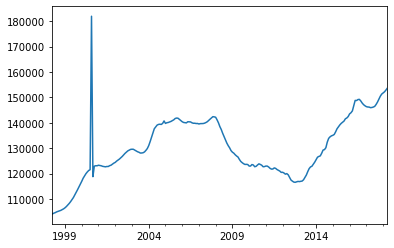

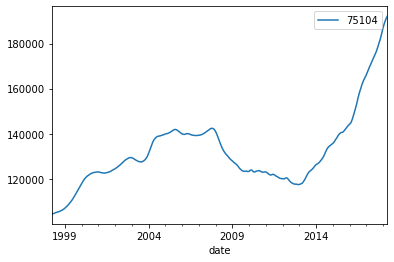

In [106]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)


# 79423

In [107]:
df_79423 = pd.DataFrame(df_p[79423][df_p[79423].notnull()]).astype(int) 
df_79423['value'] = df_79423[79423] 
df_79423.drop(df_79423.columns[np.r_[1]], axis=1, inplace=True)

In [108]:
df_79423

,79423
date,
1996-04-01,70700
1996-05-01,70900
1996-06-01,71200
1996-07-01,71500
1996-08-01,71800
...,...
2017-12-01,147900
2018-01-01,148200
2018-02-01,148200


<AxesSubplot:xlabel='date'>

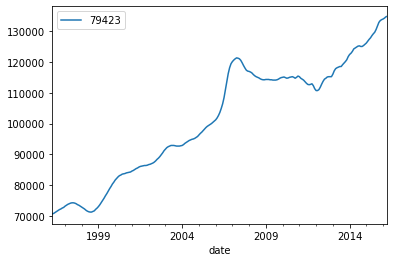

In [109]:
train =  df_79423[:-24]
test = df_79423[-241:]
train.plot()

<AxesSubplot:xlabel='date'>

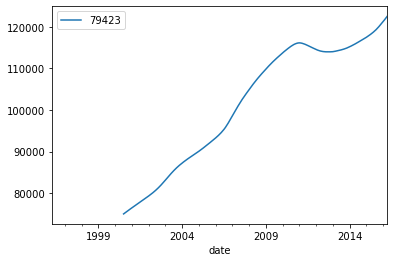

In [110]:
# Plot the rolling mean with a window of a year

roll_mean = train.rolling(window=52).mean()
roll_mean.plot()

<AxesSubplot:xlabel='date'>

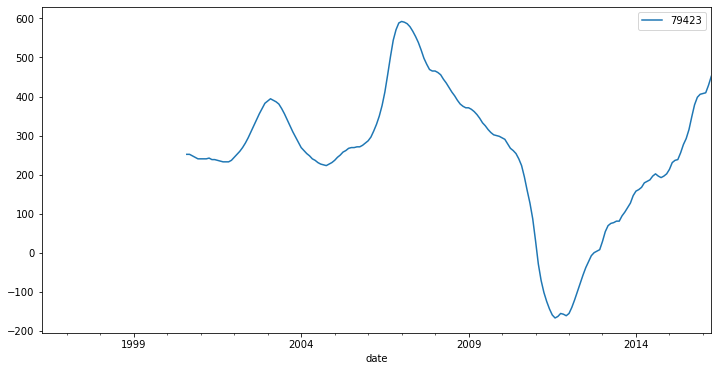

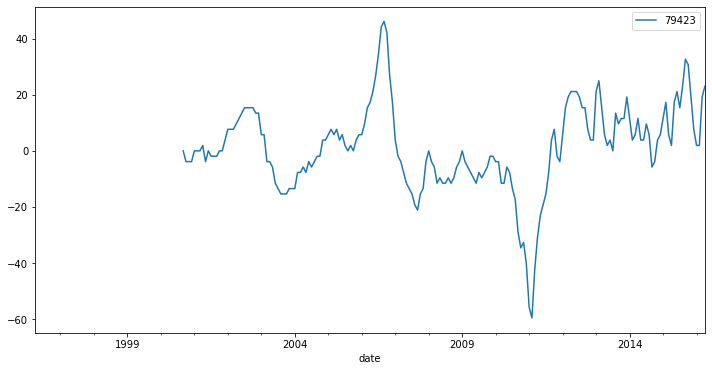

In [111]:
# Apply a 1st order difference to the time series and plot the rolling mean

rm_diff_1 = roll_mean.diff(periods=1)
rm_diff_1.plot(figsize=(12,6))


rm_diff_2 = roll_mean.diff(periods=1).diff(periods=1)
rm_diff_2.plot(figsize=(12,6))

In [112]:
def stationarity_check(df):     
    df_test = adfuller(df)
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(df_test[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key,value in df_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    return None

In [113]:
print(stationarity_check(df_79423))
print(stationarity_check(rm_diff_2.dropna()))

Results of Dickey-Fuller Test: 

Test Statistic                  -0.347471
p-value                          0.918507
#Lags Used                      14.000000
Number of Observations Used    250.000000
Critical Value (1%)             -3.456781
Critical Value (5%)             -2.873172
Critical Value (10%)            -2.572969
dtype: float64
None
Results of Dickey-Fuller Test: 

Test Statistic                  -2.413832
p-value                          0.137871
#Lags Used                      12.000000
Number of Observations Used    175.000000
Critical Value (1%)             -3.468280
Critical Value (5%)             -2.878202
Critical Value (10%)            -2.575653
dtype: float64
None


In [114]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(train, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())

                               SARIMAX Results                                
Dep. Variable:                  79423   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1873.844
Date:                Thu, 07 Oct 2021   AIC                           3753.688
Time:                        10:17:17   BIC                           3764.142
Sample:                    04-01-1996   HQIC                          3757.900
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.015e+05   3.11e+04      3.259      0.001    4.04e+04    1.62e+05
ar.L1          0.9998      0.002    404.348      0.000       0.995       1.005
sigma2      3.212e+05    1.7e+04     18.887      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [115]:
train_hat = sm.predict()
train_hat

1996-04-01    101461.004238
1996-05-01     70705.157773
1996-06-01     70905.124238
1996-07-01     71205.073936
1996-08-01     71505.023635
                  ...      
2015-12-01    133394.644711
2016-01-01    133694.594409
2016-02-01    133894.560875
2016-03-01    134194.510573
2016-04-01    134594.443504
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [148]:
df

,zipcode,city,state,county,ROI,std,mean,CV,value,year
date,,,,,,,,,,
1996-04-01,75070,McKinney,TX,Collin,0.365295,33537.101427,219655.849057,0.152680,235700.0,1996
1996-04-01,77494,Katy,TX,Harris,0.567966,37730.794353,262110.566038,0.143950,210400.0,1996
1996-04-01,79936,El Paso,TX,El Paso,0.571798,18167.079218,101875.471698,0.178326,77300.0,1996
1996-04-01,77084,Houston,TX,Harris,0.729474,17242.109812,121185.283019,0.142279,95000.0,1996
1996-04-01,77449,Katy,TX,Harris,0.846960,18603.288493,126530.188679,0.147026,95400.0,1996
...,...,...,...,...,...,...,...,...,...,...
2018-04-01,76941,Mertzon,TX,Irion,NaN,13734.029878,99318.367347,0.138283,121600.0,2018
2018-04-01,79313,Anton,TX,Hockley,NaN,5286.674724,54424.675325,0.097137,63300.0,2018
2018-04-01,79355,Plains,TX,Yoakum,NaN,12929.465872,78967.346939,0.163732,93500.0,2018


In [149]:
df['value'].median()

113700.0

In [143]:
ari_mod = ARIMA(df['value'],order=(1,1,1),enforce_stationarity=False,enforce_invertibility=False).fit()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


In [144]:
forecast = ari_mod.forecast(steps=52)

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [147]:
df['ROI'].median()

0.9033953476403684

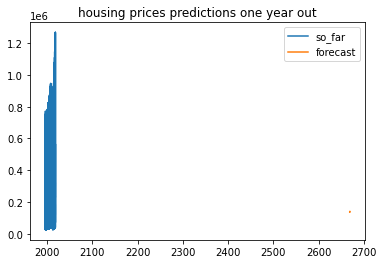

In [145]:
fig, ax = plt.subplots()
ax.plot(df['value'], label='so_far')
ax.plot(forecast,label='forecast')
ax.set_title('housing prices predictions one year out')
plt.legend();

In [116]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

2060.603097712659

In [117]:
from statsmodels.tsa.arima.model import ARIMA

arima = ARIMA(test, order=(1, 0, 0))
sm = arima.fit()
print(sm.summary())


                               SARIMAX Results                                
Dep. Variable:                  79423   No. Observations:                  241
Model:                 ARIMA(1, 0, 0)   Log Likelihood               -1892.849
Date:                Thu, 07 Oct 2021   AIC                           3791.699
Time:                        10:17:17   BIC                           3802.153
Sample:                    04-01-1998   HQIC                          3795.910
                         - 04-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.084e+05   3.59e+04      3.016      0.003    3.79e+04    1.79e+05
ar.L1          0.9999      0.002    456.886      0.000       0.996       1.004
sigma2      3.758e+05   2.15e+04     17.466      0.0

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


In [118]:
test_hat = sm.predict()
test_hat

1998-04-01    108368.471063
1998-05-01     71905.220334
1998-06-01     71605.263277
1998-07-01     71405.291907
1998-08-01     71305.306221
                  ...      
2017-12-01    147294.427088
2018-01-01    147894.341200
2018-02-01    148194.298257
2018-03-01    148194.298257
2018-04-01    147794.355515
Freq: MS, Name: predicted_mean, Length: 241, dtype: float64

In [119]:
from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(test, test_hat, squared=False)
rmse

2427.465460473967

In [120]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax = SARIMAX(train, order=[1,0,0]).fit()
sarimax.summary()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:965: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  79423   No. Observations:                  241
Model:               SARIMAX(1, 0, 0)   Log Likelihood               -1875.096
Date:                Thu, 07 Oct 2021   AIC                           3754.193
Time:                        10:17:17   BIC                           3761.162
Sample:                    04-01-1996   HQIC                          3757.000
                         - 04-01-2016                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000    8.9e-05   1.12e+04      0.000       1.000       1.000
sigma2      3.207e+05   9.41e-14   3.41e+18      0.000    3.21e+05    3.21e+05
===================================================================================
Ljung-Box (L1) (Q):                 202.16   Jarque-Bera (JB):               392.46
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.67   Skew:                             1.41
Prob(H) (two-sided):                  0.02   Kurtosis:                         8.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

In [121]:
# Calculate the training root mean squared error (same syntax as a linear regression prediction)

from sklearn.metrics import mean_squared_error
rmse = mean_squared_error(train, train_hat, squared=False)
rmse

2060.603097712659

In [122]:
def print_ts_metrics(endog=train, test=test, order=[0,0,0], seasonal_order=[0,0,0,0]):
    
    '''
    Print out RMSE for a given set of orders (seasonal and non-seasonal)
    Return the model fit on the training set.
    '''
    
    sm = SARIMAX(endog, order=order, seasonal_order=seasonal_order).fit()
    rmse_endog = mean_squared_error(endog, 
                             sm.predict(endog.index[0], endog.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    rmse_test = mean_squared_error(test, 
                             sm.predict(test.index[0], test.index[-1], 
                                        typ='levels'), 
                                        squared=False)
    print(rmse_endog)
    
    print(rmse_test)
    return sm

In [123]:

def plot_predictions(test=test, sarimax=sarimax):
    sarimax.predict(test.index[0], test.index[-1], typ='levels').plot()
    test.plot()

C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
C:\Users\sethk\anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


5154.787295280176
2633.0578863382434


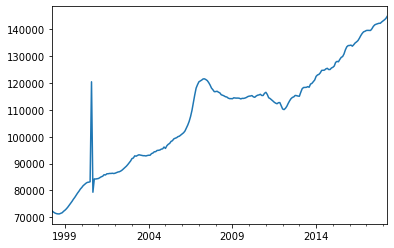

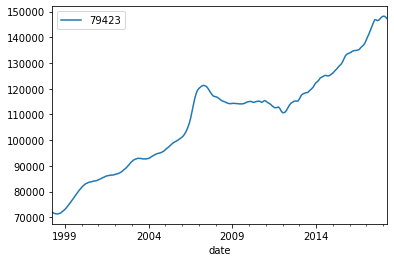

In [124]:
# set print_ts_metrics equal to model, then feed that model to plot_predictions
model = print_ts_metrics(endog=train, test=test, order=[1,1,0], seasonal_order=[1,1,0,52])
plot_predictions(test, model)

# Visulaiztions

In [125]:
zipcodes = list(df_filtered_20['zipcode'].values)
zipcodes

[79423, 77571, 76108, 75052, 75104]

In [126]:
df_prices = pd.DataFrame(df_merged[['zipcode','value']], index = df_merged.index)
df_prices.reset_index(inplace=True)

df_prices = df_prices.pivot('date', 'zipcode', 'value')
df_prices

zipcode,75052,75104,76108,77571,79423
date,,,,,
1996-04-01,100800.0,98300.0,81600.0,85500.0,70700.0
1996-05-01,100900.0,98500.0,81500.0,85600.0,70900.0
1996-06-01,101000.0,98700.0,81400.0,85800.0,71200.0
1996-07-01,101000.0,99000.0,81400.0,85900.0,71500.0
1996-08-01,101200.0,99200.0,81400.0,86000.0,71800.0
...,...,...,...,...,...
2017-12-01,194300.0,184400.0,158300.0,170300.0,147900.0
2018-01-01,195200.0,187000.0,160100.0,171800.0,148200.0
2018-02-01,196700.0,189100.0,161900.0,173100.0,148200.0


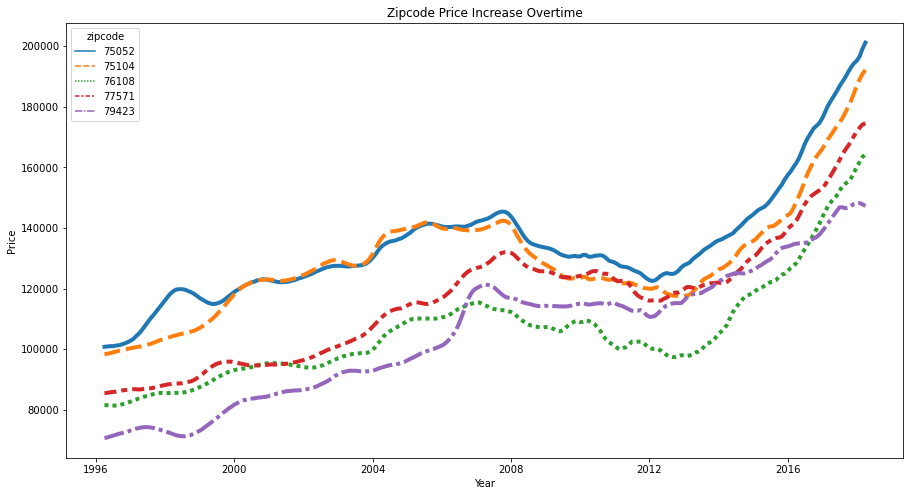

In [127]:
fig, ax = plt.subplots()
sns.lineplot(data=df_prices, linewidth=4)
fig.set_size_inches(15, 8)
ax.set_title('Zipcode Price Increase Overtime')
ax.set_xlabel('Year')
ax.set_ylabel('Price');